<a href="https://colab.research.google.com/github/diego-escobedo/NeuralODE/blob/master/Diego_Version_cnf_sinkhorn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf wassflow
git clone https://github.com/pzpzpzp1/wassflow
git clone https://github.com/rtqichen/ffjord

Cloning into 'wassflow'...
fatal: destination path 'ffjord' already exists and is not an empty directory.


In [ ]:
!pip install torchdiffeq
!pip install geomloss[full]
!pip install torchinfo


import math
import numpy as np
from IPython.display import clear_output
import pdb
import time

import matplotlib.pyplot as plt
from geomloss import SamplesLoss
import gc
from image_utils import BoundingBox, import_img, ImageDataset, make_image

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
from torchvision import models
from torchinfo import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append("/content/")

# Basic ODE Func

Models such as residual networks, recurrent neural
network decoders, and normalizing flows build complicated
transformations by composing a sequence of
transformations to a hidden state: \\
$\textbf{h}_{t+1} = \textbf{h}_t + \textit{f}(\textbf{h}_t, \theta_t)$ \\
What happens as we add more layers and take smaller
steps? In the limit, we parameterize the continuous
dynamics of hidden units using an ordinary differential
equation (ODE) specified by a neural network f: \\
$\frac{\textit{d}\textbf{h}_t}{\textit{dt}} = \textit{f}(\textbf{h}(\textit{t}), \textit{t}, \theta)$ \\
Starting from the input layer $\textbf{h}(0)$, we can define the output layer $\textbf{h}(\textit{T})$ to be the solution to this
ODE initial value problem at some time $\textit{T}$. This value can be computed by a black-box differential
equation solver, which evaluates the hidden unit dynamics f wherever necessary to determine the
solution with the desired accuracy

In [ ]:
TIME_PROJECTION_DIMS = 64
VECTOR_FIELD_DIMENSIONS = 2
HIDDEN_SIZE = 128

class DerivNN(nn.Module):
  """ Neural Network used to 

      Time Representation using "Time2Vec: Learning a Vector Representation of Time" - https://arxiv.org/pdf/1907.05321.pdf 
  """
  def __init__(self):
    super(DerivNN, self).__init__()

    #time related
    self.time_proj_unactivated = nn.Linear(1, 1, bias=True) # will take from 1x1 -> 1x1 
    self.time_proj_activated = nn.Linear(1, TIME_PROJECTION_DIMS, bias=True)

    #event related
    self.fc1 = nn.Linear(VECTOR_FIELD_DIMENSIONS, HIDDEN_SIZE)
    self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
    
    #combination
    self.combination_fc = nn.Linear(HIDDEN_SIZE+TIME_PROJECTION_DIMS+1, VECTOR_FIELD_DIMENSIONS)

  def forward(self, t, state):
    #project time onto same dimension as vector
    t = torch.reshape(t, (-1, 1))
    tp_unactivated = self.time_proj_unactivated(t) # 1 x 1
    tp_activated = torch.sin(self.time_proj_activated(t)) # 1 x TIME_PROJECTION_DIMS
    time_projection = torch.cat((tp_unactivated, tp_activated), dim=1) # 1 x TIME_PROJECTION_DIMS+1
    time_projection = time_projection.repeat(state.shape[0], 1) # num_samples x TIME_PROJECTION_DIMS+1

    #transform event to get nonlinearities ... event is num_samples x d_in
    sp = nn.Softplus()
    event = sp(self.fc1(state)) # num_samples x HIDDEN_SIZE
    event = sp(self.fc2(event)) # num_samples x HIDDEN_SIZE

    #concatenate the two, adding the hidden 
    combined = torch.cat((event, time_projection), dim=1)
    output = self.combination_fc(combined)

    return output


# FFJORD Model for Continuous Normalizing Flows

In [ ]:
from ffjord.lib.layers.cnf import CNF
from ffjord.lib.layers.odefunc import ODEfunc, _get_minibatch_jacobian
from ffjord.lib.layers.container import SequentialFlow

In [ ]:
fn = ODEfunc(DerivNN())
model = CNF(fn)

In [ ]:
summary(base_model, (64,2))

# Evaluation + Results

In [ ]:
# colors = ['red','orange','magenta','cyan']
colors = ['green','green','green','green']


import os
def save_trajectory(model,z_target, my_loss, savedir='imgs', nsteps=20, memory=0.01, n=1000, reverse=False):
    """
    Plot the dynamics of the learned ODE.
    Saves images to `savedir`.
    Parameters
    ----------
    model : FfjordModel
        Model defining the dynamics.
    z_target : torch.Tensor 
        Tensor of shape (T,n,d) where T is the number of timesteps
    myloss : str
        Name of loss used to train the model
    savedir : str, optional
        Where to save output.
    ntimes : int, optional
        Number of timesteps to visualize.
    memory : float
        Controls how finely the density grid is sampled.
    n : int, optional
        Number of samples to visualize.
    """
    
    BB = BoundingBox(z_target);
    z_sample = BB.sampleuniform(t_N = 1, x_N = 20, y_N = 20);
        
    if reverse: 
        my_loss += '_neg';
    
    final_dir = savedir+'/'+my_loss
    if not os.path.exists(final_dir):
        os.makedirs(final_dir)
    
    T = z_target.shape[0]
    integration_times = torch.linspace(0,T-1,nsteps).to(device);
    if reverse:
        x_traj = model(z_target[T-1,:,:], integration_times, reverse=reverse)
    else:
        print(z_target.shape)
        x_traj = model(z_target[0,:,:], integration_times, reverse=reverse)
    
    x_traj = x_traj.detach().cpu().numpy()

    for i in range(nsteps):
        t = integration_times[i];
        if reverse:
            t = integration_times[(T-1)-i];
        
        z_dots = model.odefunc.get_z_dot(z_sample[:,0]*0.0 + t, z_sample[:,1:]);
        z_sample_d = z_sample.cpu().detach().numpy();
        z_dots_d = z_dots.cpu().detach().numpy();
        plt.quiver(z_sample_d[:,1], z_sample_d[:,2], z_dots_d[:,0], z_dots_d[:,1])
        
        plt.scatter(x_traj[i,:,0], x_traj[i,:,1], s=10, alpha=.5, linewidths=0, c='blue', edgecolors='black')
        for t in range(T):
            plt.scatter(z_target.cpu().detach().numpy()[t,:,0], z_target.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c=colors[t], edgecolors='black')
        plt.axis('equal')
        plt.savefig(os.path.join(final_dir, f"viz-{i:05d}.jpg"))
        plt.clf()

    trajectory_to_video(my_loss, savedir, mp4_fn='transform.mp4')


def trajectory_to_video(my_loss,savedir='imgs', mp4_fn='transform.mp4'):
    """Save the images written by `save_trajectory` as an mp4."""
    import subprocess
    final_dir = savedir+'/'+my_loss
    img_fns = os.path.join(final_dir, 'viz-%05d.jpg')
    video_fn = os.path.join(final_dir, mp4_fn)
    bashCommand = 'ffmpeg -y -i {} {}'.format(img_fns, video_fn)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()



In [ ]:
def base_loss(output, target, loss_name='sinkhorn_small_reg'):
    loss_fn = SamplesLoss("energy") if loss_name=="energy_distance" else (SamplesLoss("sinkhorn", p=2, blur=0.01) if loss_name=="sinkhorn_large_reg" else SamplesLoss("sinkhorn", p=2, blur=1))
    init_loss = loss_fn(output, target)
    return init_loss

def alt_loss(z_dots, zt_jacs, losses={}):
    alternative_losses = dict()
    for loss, reg_lambda in losses.items():
      if loss=="divergence_squared":
        alt_loss = (zt_jacs[:,0,0]+zt_jacs[:,1,1])**2
      elif loss=="square_norm_curl":
        alt_loss = (zt_jacs[:,0,1]-zt_jacs[:,1,0])**2
      elif loss=="rigid_motion": # rigid motion: x(t) -> e^[wt] x0 + kt. v = x_dot = [w]x0+k; dvdx = [w]. ==> skew symmetric velocity gradient is rigid.
        alt_loss=((zt_jacs[:,0,1]+zt_jacs[:,1,0])**2)/2 + (zt_jacs[:,0,0])**2 + (zt_jacs[:,1,1])**2 
      elif loss=="v_field_gradient":
        alt_loss = zt_jacs[:,0,0]**2 + zt_jacs[:,1,1]**2+zt_jacs[:,0,1]**2 + zt_jacs[:,1,0]**2
      elif loss=="kinetic_energy":
        alt_loss = z_dots[:,0]**2 + z_dots[:,1]**2
      else:
        raise ValueError(f'Specified alternative loss {loss} could not be found')

      alternative_losses[loss] = reg_lambda * alt_loss
        
    return alternative_losses

In [ ]:
def normalize_samples(z_target):
    ## normalize a [K,N,D] tensor. K is number of frames. N is number of samples. D is dimension. Fit into [0,1] box without changing aspect ratio.
    dim = z_target.shape[2]
    z_target -= z_target.reshape(-1,dim).min(0)[0]
    z_target /= z_target.reshape(-1,dim).max()
    return z_target

def learn_trajectory(z_target_full, model, loss='sinkhorn_small_reg', regularization_losses={}, n_iters = 10, batch_size = 100, save=False):
    """
    Learns a trajectory between multiple timesteps contained in z_target
    ----------
    z_target_full : torch.Tensor 
        Tensor of shape (T,n,d) where T is the number of timesteps, n is the number of data points available, and d is the dimensions of the vector field
    loss : str
        Data fidelity loss, either 'sinkhorn_large_reg', 'sinkhorn_small_reg' or 'energy_distance'
    regularization_loss : dict
        dictionary of desired regularization losses, mapped from their name to their weight. E.g. {"divergence_squared":0.5, "kinetic_energy":0.25}
    model : FFJORD model
        the model we're going to be using for teh hwole thing
    Returns
    -------
    model : 
        NN representing the vector field
    
    """
    loss_name = loss
    z_target_full = normalize_samples(z_target_full) # normalize to fit in [0,1] box.

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    T = z_target_full.shape[0]

#   get spacetime bounding box and spacetime sample grid
    BB = BoundingBox(z_target_full)
    
    losses = []
    start = time.time()
    print(f'training with {loss_name}, regularization losses{regularization_losses.keys}')
    start0 = time.time()
    for batch in range(n_iters):                
        if (batch % 30 == 1):
            start = time.time()

        # subsample z_target_full to z_target for loss computation --> z_target will be [T, batch_size, d]
        fullshape = z_target_full.shape # [T, batch_size, d]
        z_target = torch.zeros([fullshape[0], batch_size, fullshape[2]]).to(z_target_full)
        for i in range(fullshape[0]):
            subsample_inds = torch.randint(0, high=fullshape[1], size=[batch_size])
            z_target[i,:,:] = z_target_full[i,subsample_inds,:]


        optimizer.zero_grad()
    
        ## FORWARD and BACKWARD fitting loss
        fitloss_checkpoint = time.time()
        # integrate ODE forward in time
        
        z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device))
        fitloss = torch.tensor(0.).to(device)
        for t in range(1,T):
            fitloss += base_loss(z_t[t,:,:], z_target[t,:,:], loss_name=loss)
        if batch==0:
            # scaling factor chosen at start to normalize fitting loss
            fitloss0 = fitloss.item() # constant. not differentiated through
        fitloss /= fitloss0

        # integrate ODE backward in time from last keyframe
        z_t_b = model(z_target[T-1,:,:], integration_times = torch.linspace(0,T-1,T).to(device), reverse=True)
        fitlossB = torch.tensor(0.).to(device)
        for t in range(1,T):
            fitlossB += base_loss(z_target[(T-1)-t,:,:], z_t_b[t,:,:], loss_name=loss)
        if batch==0:
            # scaling factor chosen at start to normalize fitting loss
            fitlossB0 = fitlossB.item() # constant. not differentiated through
        fitlossB /= fitlossB0  

        fitlosstime = time.time()-fitloss_checkpoint  

        # ## apply regularization losses
        regloss_checkpoint = time.time()
        # #sample from boundingbox
        # z_sample = BB.samplerandom(N = 3000, bbscale = 1.1)
        # z_dots = model.odefunc.diffeq(z_sample[:,0], z_sample[:,1:])
        # zt_jacs = _get_minibatch_jacobian(z_sample[:,0], z_sample[:,1:])
        # reg_loss_dict = alt_loss(z_dots, zt_jacs, losses=regularization_losses) #we can log this wherever we want, if necessary
        # reg_loss = sum([vectorized_loss.mean().item() for _, vectorized_loss in reg_loss_dict.items()])

        reglosstime = time.time()-regloss_checkpoint

        #combine the losses, log, and then step
        totalloss = fitloss + fitlossB #+ reg_loss
        losses.append(totalloss.item())
        totalloss.backward()
        optimizer.step()
        
        if (batch % 30 == 0):
            print('batch',batch,'loss',loss)
            plt.scatter(z_target.cpu().detach().numpy()[0,:,0], z_target.cpu().detach().numpy()[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
            for t in range(1,T):
                plt.scatter(z_t_b.cpu().detach().numpy()[t,:,0], z_t_b.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
                plt.scatter(z_t.cpu().detach().numpy()[t,:,0], z_t.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c='blue', edgecolors='black')
                plt.scatter(z_target.cpu().detach().numpy()[t,:,0], z_target.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c=colors[t], edgecolors='black')
            plt.axis('equal')
            plt.show()
            
            ptime = time.time()-start
            print('fit time ',round(fitlosstime, 4),' reg loss time', round(reglosstime,4) )
            print('time elapsed on iter', ptime,'total time', time.time()-start0)
            print('batch number', batch,'out of', n_iters)
            
            if save:
                save_state(model, fn='models/state_' + f"{batch:04}" + '_time_' + str(ptime) + '_' + str(losses[batch]) + '.tar')
                save_trajectory(model,z_target,my_loss + "_" + f"{batch:04}", savedir='imgs', nsteps=20, memory=0.01, n=1000)
                save_trajectory(model,z_target,my_loss + "_" + f"{batch:04}", savedir='imgs', nsteps=20, memory=0.01, n=1000, reverse = True)

        # fitloss.detach();
        # fitlossB.detach();
        # z_t.detach();
        # z_t_b.detach();
        # loss.detach();
        # del loss;
        torch.cuda.empty_cache()
    return model, losses


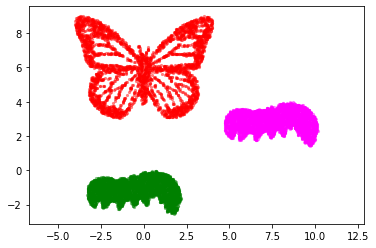

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

caterpillar = 1-import_img('wassflow/caterpillar.png')
caterpillar /= caterpillar.max()

butterfly = 255-import_img('wassflow/butterfly.jpg')
butterfly /= butterfly.max()

dset1 = ImageDataset(img=caterpillar*1,thresh=.8) 
dset2 = ImageDataset(img=butterfly*1,thresh=.8)


n = 4000
dat1 = dset1.sample(n)
dat2 = dset2.sample(n)
dat3 = dset1.sample(n)
#neg to pos
dat1 *= -1 
dat2 *= -1 
dat3 *= -1
#move caterpillar 1 to the left, butterfly 5 up, other caterpillar up and right
dat1[:,1] -= 1
dat2[:,1] += 5 
dat3[:,0] += 8
dat3[:,1] += 3

plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='green')
plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='red')
plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='magenta')
plt.axis('equal')
plt.show() 

training with sinkhorn_small_reg, regularization losses<built-in method keys of dict object at 0x7f4f750ff820>


/content/ffjord/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


batch 0 loss sinkhorn_small_reg


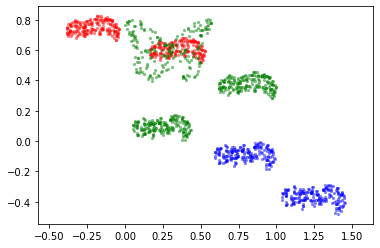

fit time  0.073  reg loss time 0.0
time elapsed on iter 0.4084513187408447 total time 0.408707857131958
batch number 0 out of 1500
batch 30 loss sinkhorn_small_reg


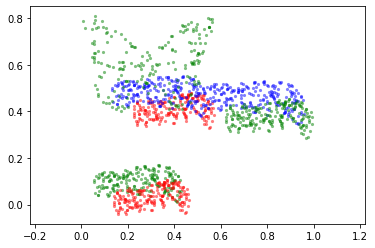

fit time  0.0971  reg loss time 0.0
time elapsed on iter 8.17646050453186 total time 8.58599305152893
batch number 30 out of 1500
batch 60 loss sinkhorn_small_reg


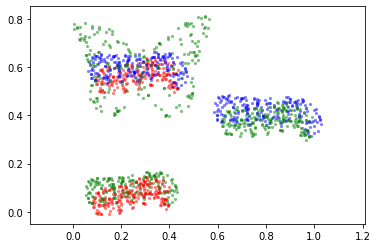

fit time  0.1044  reg loss time 0.0
time elapsed on iter 8.96078085899353 total time 17.54754376411438
batch number 60 out of 1500
batch 90 loss sinkhorn_small_reg


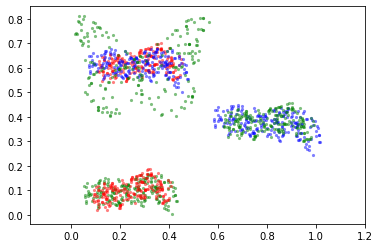

fit time  0.093  reg loss time 0.0
time elapsed on iter 8.812189102172852 total time 26.37264609336853
batch number 90 out of 1500
batch 120 loss sinkhorn_small_reg


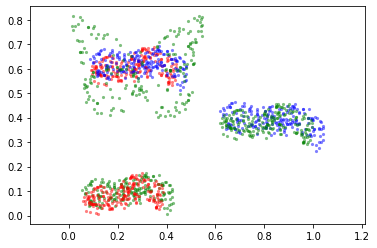

fit time  0.0894  reg loss time 0.0
time elapsed on iter 8.759474515914917 total time 35.13342046737671
batch number 120 out of 1500
batch 150 loss sinkhorn_small_reg


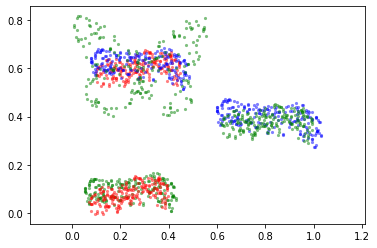

fit time  0.088  reg loss time 0.0
time elapsed on iter 8.738949298858643 total time 43.87268829345703
batch number 150 out of 1500
batch 180 loss sinkhorn_small_reg


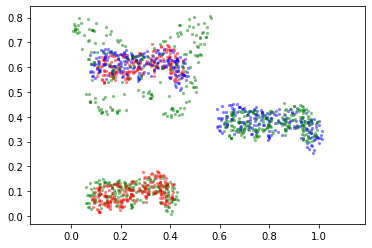

fit time  0.0825  reg loss time 0.0
time elapsed on iter 8.771783590316772 total time 52.64474296569824
batch number 180 out of 1500
batch 210 loss sinkhorn_small_reg


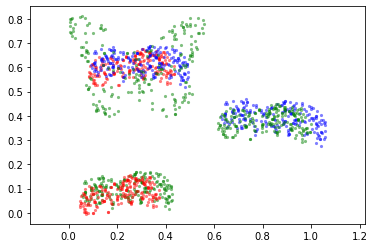

fit time  0.0849  reg loss time 0.0
time elapsed on iter 8.784144639968872 total time 61.42921566963196
batch number 210 out of 1500
batch 240 loss sinkhorn_small_reg


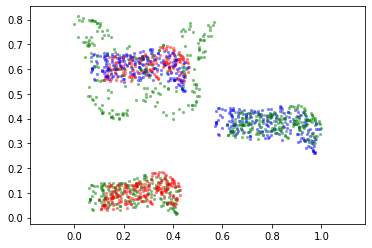

fit time  0.0958  reg loss time 0.0
time elapsed on iter 8.84200382232666 total time 70.27359414100647
batch number 240 out of 1500
batch 270 loss sinkhorn_small_reg


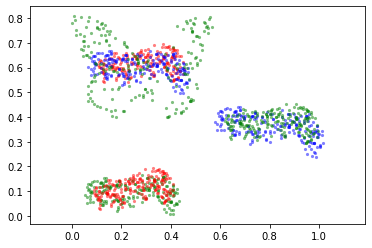

fit time  0.0845  reg loss time 0.0
time elapsed on iter 8.81380581855774 total time 79.08832454681396
batch number 270 out of 1500
batch 300 loss sinkhorn_small_reg


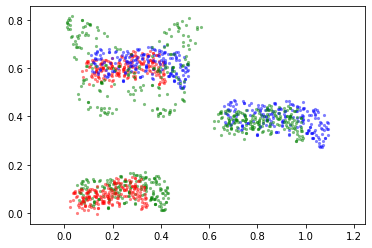

fit time  0.0954  reg loss time 0.0
time elapsed on iter 8.762356519699097 total time 87.85106301307678
batch number 300 out of 1500
batch 330 loss sinkhorn_small_reg


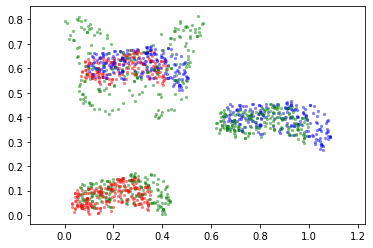

fit time  0.0884  reg loss time 0.0
time elapsed on iter 8.8351891040802 total time 96.69028973579407
batch number 330 out of 1500
batch 360 loss sinkhorn_small_reg


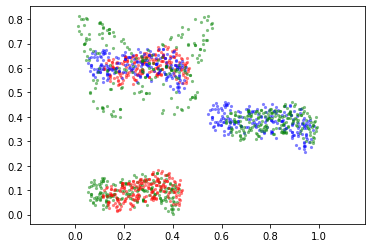

fit time  0.0893  reg loss time 0.0
time elapsed on iter 8.889200448989868 total time 105.58018779754639
batch number 360 out of 1500
batch 390 loss sinkhorn_small_reg


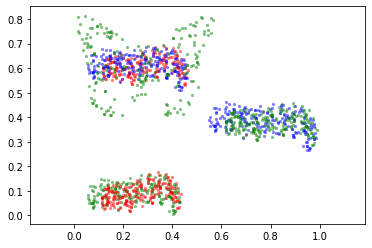

fit time  0.084  reg loss time 0.0
time elapsed on iter 8.703572750091553 total time 114.28480577468872
batch number 390 out of 1500
batch 420 loss sinkhorn_small_reg


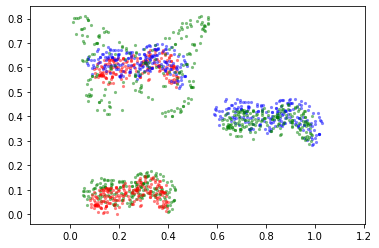

fit time  0.0886  reg loss time 0.0
time elapsed on iter 8.826974153518677 total time 123.11275005340576
batch number 420 out of 1500
batch 450 loss sinkhorn_small_reg


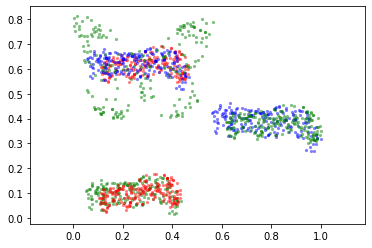

fit time  0.0875  reg loss time 0.0
time elapsed on iter 8.768480062484741 total time 131.88283896446228
batch number 450 out of 1500
batch 480 loss sinkhorn_small_reg


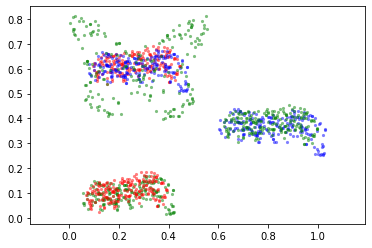

fit time  0.1048  reg loss time 0.0
time elapsed on iter 8.703391790390015 total time 140.58724641799927
batch number 480 out of 1500
batch 510 loss sinkhorn_small_reg


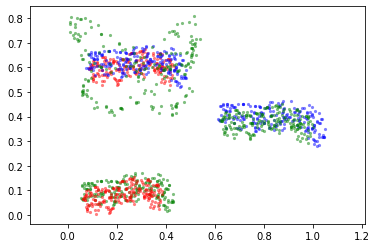

fit time  0.0911  reg loss time 0.0
time elapsed on iter 8.71236777305603 total time 149.30071425437927
batch number 510 out of 1500
batch 540 loss sinkhorn_small_reg


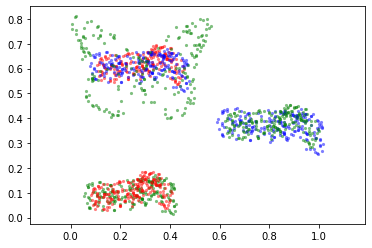

fit time  0.0835  reg loss time 0.0
time elapsed on iter 8.6719331741333 total time 157.97349381446838
batch number 540 out of 1500
batch 570 loss sinkhorn_small_reg


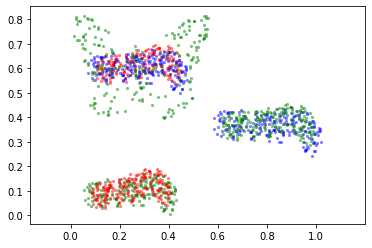

fit time  0.082  reg loss time 0.0
time elapsed on iter 8.97525405883789 total time 166.94912910461426
batch number 570 out of 1500
batch 600 loss sinkhorn_small_reg


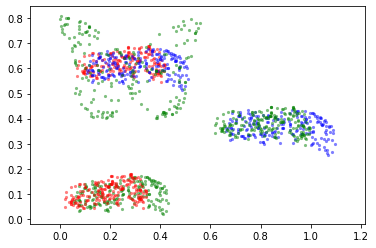

fit time  0.106  reg loss time 0.0
time elapsed on iter 8.899316549301147 total time 175.84920263290405
batch number 600 out of 1500
batch 630 loss sinkhorn_small_reg


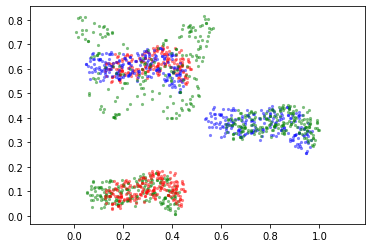

fit time  0.0846  reg loss time 0.0
time elapsed on iter 8.836078643798828 total time 184.68561911582947
batch number 630 out of 1500
batch 660 loss sinkhorn_small_reg


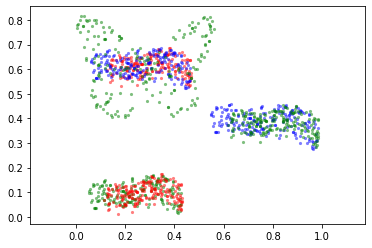

fit time  0.0917  reg loss time 0.0
time elapsed on iter 8.796726703643799 total time 193.48272562026978
batch number 660 out of 1500
batch 690 loss sinkhorn_small_reg


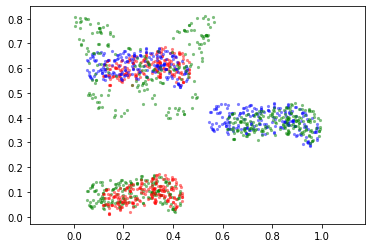

fit time  0.0856  reg loss time 0.0
time elapsed on iter 8.799108505249023 total time 202.28246641159058
batch number 690 out of 1500
batch 720 loss sinkhorn_small_reg


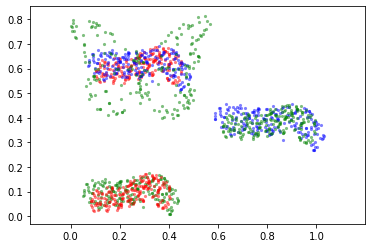

fit time  0.0867  reg loss time 0.0
time elapsed on iter 8.792837381362915 total time 211.07565999031067
batch number 720 out of 1500
batch 750 loss sinkhorn_small_reg


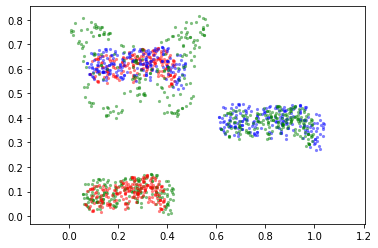

fit time  0.0959  reg loss time 0.0
time elapsed on iter 8.858657121658325 total time 219.94265341758728
batch number 750 out of 1500
batch 780 loss sinkhorn_small_reg


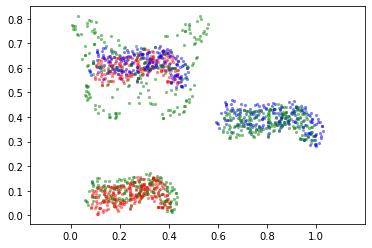

fit time  0.0881  reg loss time 0.0
time elapsed on iter 8.82021951675415 total time 228.76310396194458
batch number 780 out of 1500
batch 810 loss sinkhorn_small_reg


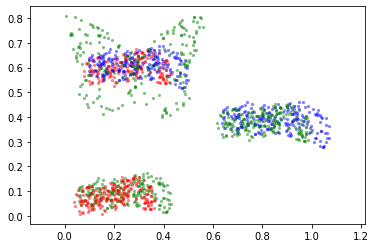

fit time  0.0823  reg loss time 0.0
time elapsed on iter 8.760151624679565 total time 237.52726221084595
batch number 810 out of 1500
batch 840 loss sinkhorn_small_reg


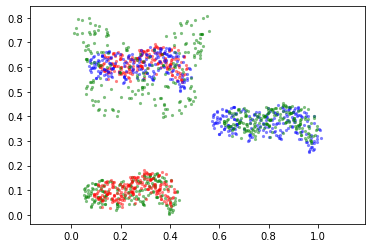

fit time  0.0907  reg loss time 0.0
time elapsed on iter 8.814677953720093 total time 246.3423409461975
batch number 840 out of 1500
batch 870 loss sinkhorn_small_reg


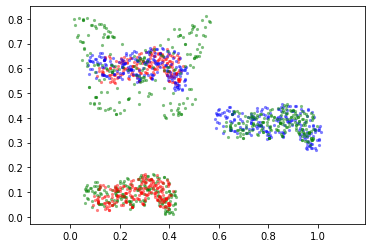

fit time  0.0996  reg loss time 0.0
time elapsed on iter 8.914215564727783 total time 255.25688576698303
batch number 870 out of 1500
batch 900 loss sinkhorn_small_reg


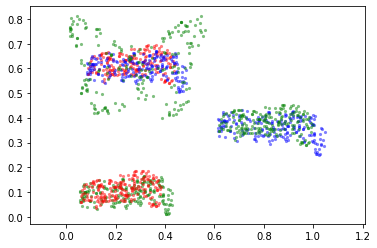

fit time  0.0881  reg loss time 0.0
time elapsed on iter 8.974225997924805 total time 264.2314648628235
batch number 900 out of 1500
batch 930 loss sinkhorn_small_reg


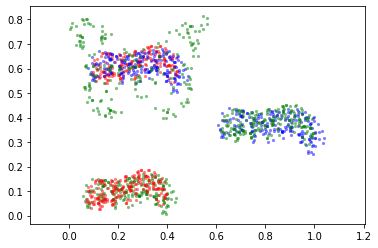

fit time  0.0873  reg loss time 0.0
time elapsed on iter 8.795132160186768 total time 273.0269343852997
batch number 930 out of 1500
batch 960 loss sinkhorn_small_reg


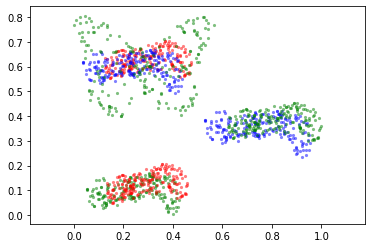

fit time  0.0846  reg loss time 0.0
time elapsed on iter 8.653764963150024 total time 281.681077003479
batch number 960 out of 1500
batch 990 loss sinkhorn_small_reg


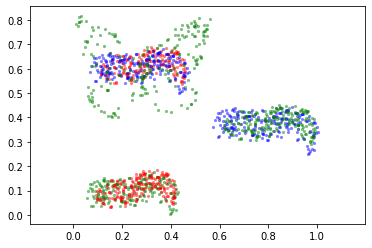

fit time  0.0992  reg loss time 0.0
time elapsed on iter 8.834357023239136 total time 290.51609444618225
batch number 990 out of 1500
batch 1020 loss sinkhorn_small_reg


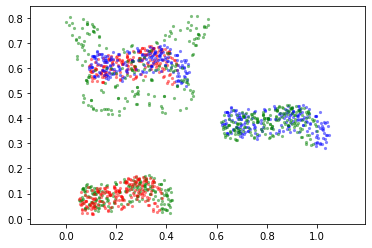

fit time  0.0909  reg loss time 0.0
time elapsed on iter 8.796223402023315 total time 299.31283497810364
batch number 1020 out of 1500
batch 1050 loss sinkhorn_small_reg


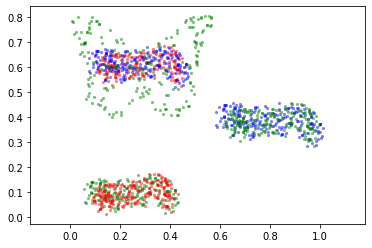

fit time  0.0875  reg loss time 0.0
time elapsed on iter 8.91173768043518 total time 308.22575426101685
batch number 1050 out of 1500
batch 1080 loss sinkhorn_small_reg


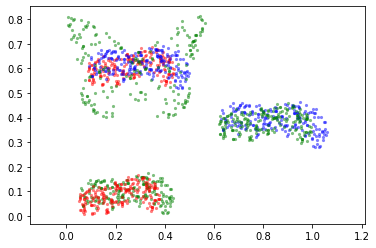

fit time  0.0879  reg loss time 0.0
time elapsed on iter 8.752460479736328 total time 316.9785273075104
batch number 1080 out of 1500
batch 1110 loss sinkhorn_small_reg


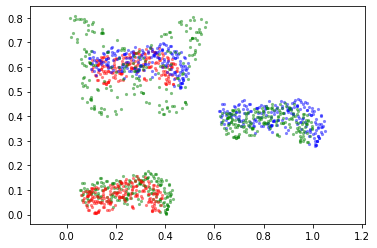

fit time  0.088  reg loss time 0.0
time elapsed on iter 8.842576503753662 total time 325.82158493995667
batch number 1110 out of 1500
batch 1140 loss sinkhorn_small_reg


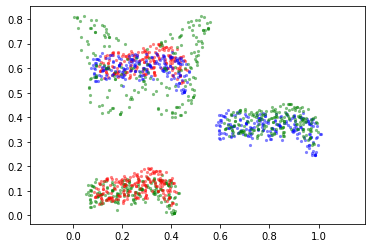

fit time  0.0886  reg loss time 0.0
time elapsed on iter 8.929942607879639 total time 334.7519018650055
batch number 1140 out of 1500
batch 1170 loss sinkhorn_small_reg


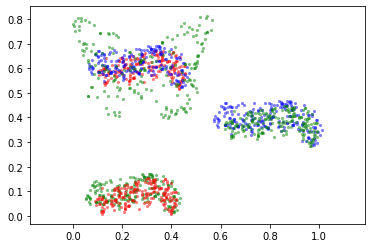

fit time  0.0832  reg loss time 0.0
time elapsed on iter 8.799679517745972 total time 343.55382561683655
batch number 1170 out of 1500
batch 1200 loss sinkhorn_small_reg


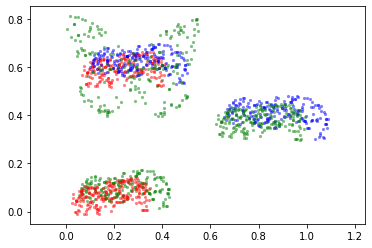

fit time  0.0852  reg loss time 0.0
time elapsed on iter 8.751741886138916 total time 352.3058922290802
batch number 1200 out of 1500
batch 1230 loss sinkhorn_small_reg


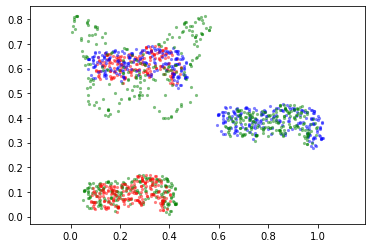

fit time  0.0863  reg loss time 0.0
time elapsed on iter 8.929097175598145 total time 361.2353241443634
batch number 1230 out of 1500
batch 1260 loss sinkhorn_small_reg


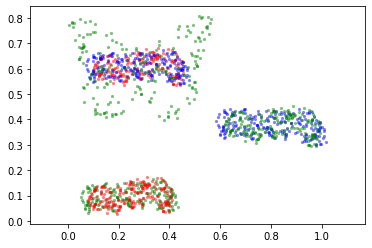

fit time  0.0844  reg loss time 0.0
time elapsed on iter 8.798766136169434 total time 370.0344309806824
batch number 1260 out of 1500
batch 1290 loss sinkhorn_small_reg


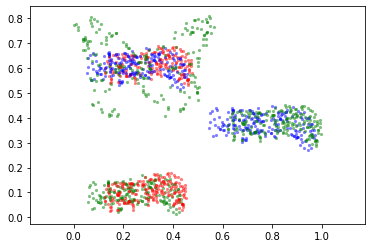

fit time  0.0996  reg loss time 0.0
time elapsed on iter 8.804329872131348 total time 378.8393349647522
batch number 1290 out of 1500
batch 1320 loss sinkhorn_small_reg


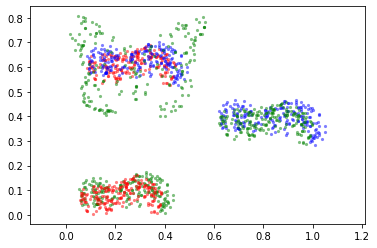

fit time  0.0886  reg loss time 0.0
time elapsed on iter 8.840859651565552 total time 387.6813955307007
batch number 1320 out of 1500
batch 1350 loss sinkhorn_small_reg


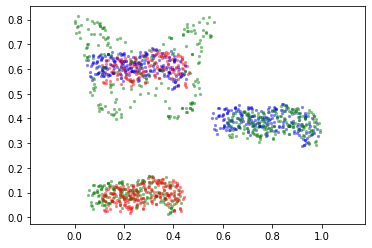

fit time  0.098  reg loss time 0.0
time elapsed on iter 8.815099000930786 total time 396.4968087673187
batch number 1350 out of 1500
batch 1380 loss sinkhorn_small_reg


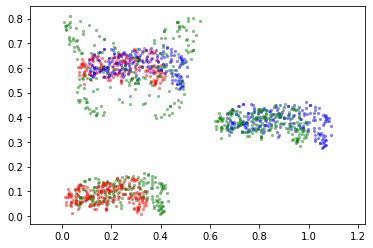

fit time  0.0858  reg loss time 0.0
time elapsed on iter 8.91530156135559 total time 405.4124619960785
batch number 1380 out of 1500
batch 1410 loss sinkhorn_small_reg


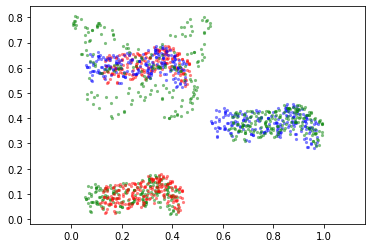

fit time  0.0882  reg loss time 0.0
time elapsed on iter 8.849923849105835 total time 414.2647936344147
batch number 1410 out of 1500
batch 1440 loss sinkhorn_small_reg


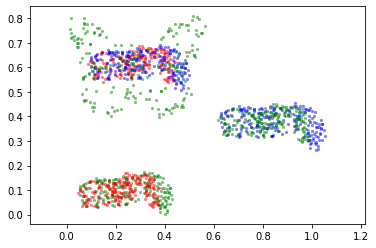

fit time  0.0861  reg loss time 0.0
time elapsed on iter 8.9129798412323 total time 423.1781196594238
batch number 1440 out of 1500
batch 1470 loss sinkhorn_small_reg


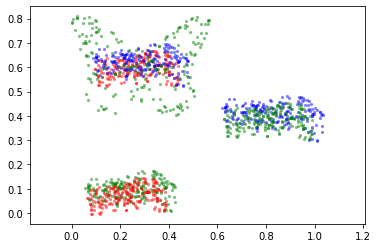

fit time  0.0836  reg loss time 0.0
time elapsed on iter 8.944693088531494 total time 432.12341713905334
batch number 1470 out of 1500


In [ ]:
dat_tuple = (dat1,dat2,dat3)
z_target = torch.stack(dat_tuple).to(device)

model = model 
my_loss = 'sinkhorn_small_reg'
model, losses = learn_trajectory(z_target, model, n_iters=1500, batch_size=200, save=False)

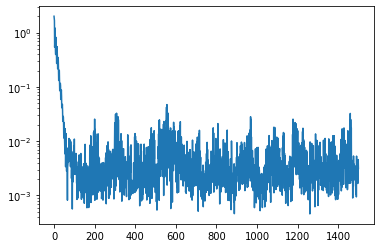

In [ ]:
y = losses
plt.yscale("log")
plt.plot(y)

In [ ]:
save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000,reverse=True)

training with sinkhorn_small_reg, regularization losses<built-in method keys of dict object at 0x7f4f750ff820>


/content/ffjord/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


batch 0 loss sinkhorn_small_reg


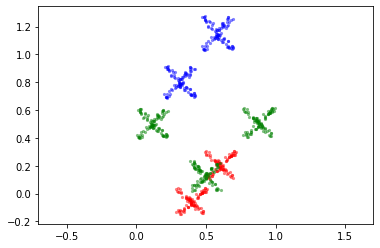

fit time  0.0662  reg loss time 0.0
time elapsed on iter 0.38668107986450195 total time 0.3892664909362793
batch number 0 out of 100
batch 30 loss sinkhorn_small_reg


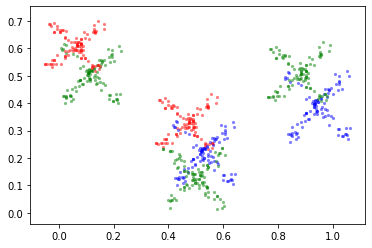

fit time  0.0743  reg loss time 0.0
time elapsed on iter 7.8923890590667725 total time 8.28576135635376
batch number 30 out of 100
batch 60 loss sinkhorn_small_reg


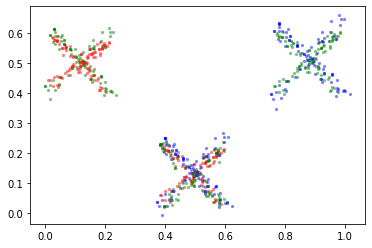

fit time  0.0841  reg loss time 0.0
time elapsed on iter 8.594960451126099 total time 16.881350994110107
batch number 60 out of 100
batch 90 loss sinkhorn_small_reg


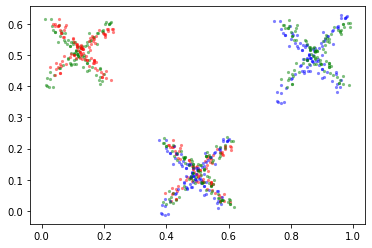

fit time  0.086  reg loss time 0.0
time elapsed on iter 8.920775175094604 total time 25.802778482437134
batch number 90 out of 100
torch.Size([3, 512, 2])


RuntimeError: ignored

In [ ]:
# Example with 3 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))
dat3 = torch.add(dat,torch.tensor([20,0]))
dat_tuple = (dat,dat2,dat3)
z_target = torch.stack(dat_tuple).to(device)

fn1 = ODEfunc(DerivNN())
model1 = CNF(fn1)
for my_loss in ['sinkhorn_small_reg']:
    model, losses = learn_trajectory(z_target, model1,n_iters=100,batch_size=100)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)

In [ ]:
z_target[0]

tensor([[0.2031, 0.4238],
        [0.1422, 0.5278],
        [0.0680, 0.5775],
        ...,
        [0.0549, 0.4174],
        [0.0811, 0.4638],
        [0.1697, 0.4680]], device='cuda:0')

training with sinkhorn_large_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


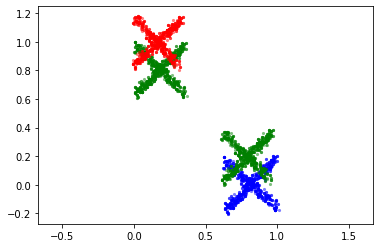

fit time  0.08632755279541016  reg loss time 0.0038700103759765625
time elapsed 0.35529088973999023 total time 0.35562658309936523
batch number 0 out of 10
training with sinkhorn_small_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


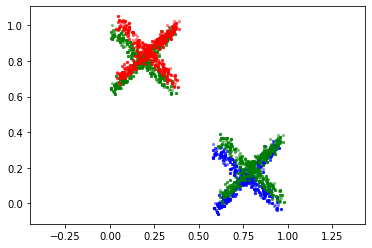

fit time  0.05565214157104492  reg loss time 0.0030934810638427734
time elapsed 0.3461589813232422 total time 0.3463113307952881
batch number 0 out of 10
training with energy_dist
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


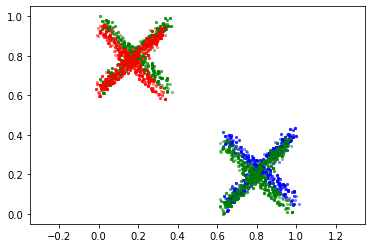

fit time  0.047937870025634766  reg loss time 0.0035948753356933594
time elapsed 0.34041571617126465 total time 0.34056615829467773
batch number 0 out of 10


<Figure size 432x288 with 0 Axes>

In [ ]:
# Example with 2 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))

dat_tuple = (dat,dat2)
z_target = torch.stack(dat_tuple).to(device)

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model, losses, separate_losses = learn_trajectory(z_target, my_loss=my_loss, n_subsample=1000)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


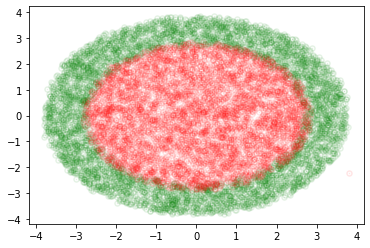

In [ ]:
#trying other shapes

# square = np.zeros([20,20])
# square[6:14,:8] = 1

# two_square = np.zeros([20,20])
# two_square[:5,14:] = 1
# two_square[15:,14:] = 1


annulus = import_img('wassflow/annulus.png')
annulus /= annulus.max()

circle = 255-import_img('wassflow/circle.jpeg')
circle /= circle.max()

dset = ImageDataset(img=annulus)
dset1 = ImageDataset(img=circle)

n = 5000
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

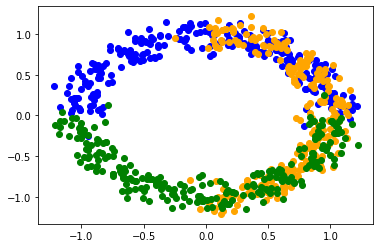

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

training with sinkhorn_large_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


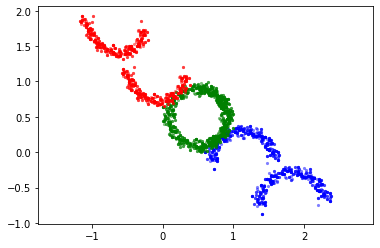

fit time  0.1104118824005127  reg loss time 0.0046923160552978516
time elapsed 0.4998784065246582 total time 0.5022261142730713
batch number 0 out of 10
training with sinkhorn_small_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


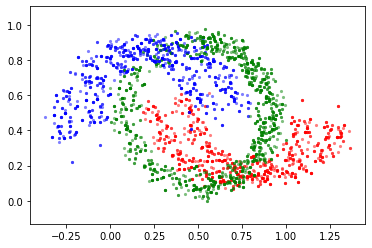

fit time  0.09596920013427734  reg loss time 0.004547595977783203
time elapsed 0.5214686393737793 total time 0.520458459854126
batch number 0 out of 10
training with energy_dist
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


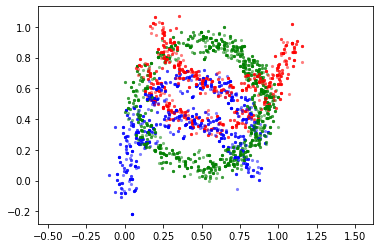

fit time  0.05716204643249512  reg loss time 0.003838062286376953
time elapsed 0.44147253036499023 total time 0.44182372093200684
batch number 0 out of 10


<Figure size 432x288 with 0 Axes>

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model, losses, separate_losses = learn_trajectory(z_target, my_loss=my_loss,n_subsample=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


training with sinkhorn_large_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


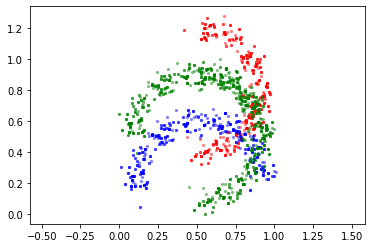

fit time  0.0719614028930664  reg loss time 0.004469156265258789
time elapsed 0.37497425079345703 total time 0.37502145767211914
batch number 0 out of 10
training with sinkhorn_small_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


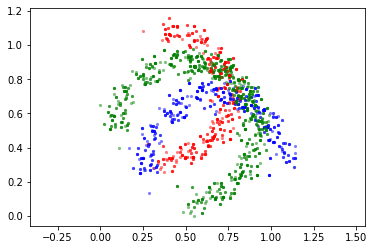

fit time  0.05750298500061035  reg loss time 0.003565073013305664
time elapsed 0.37148356437683105 total time 0.37175416946411133
batch number 0 out of 10
training with energy_dist
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


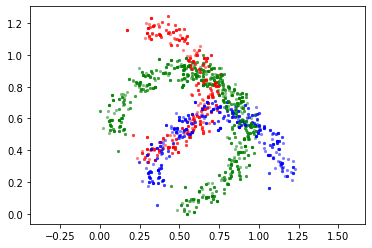

fit time  0.06405425071716309  reg loss time 0.0050601959228515625
time elapsed 0.373089075088501 total time 0.3721599578857422
batch number 0 out of 10


<Figure size 432x288 with 0 Axes>

In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model, losses, separate_losses = learn_trajectory(z_target, my_loss=my_loss,n_subsample=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
files = os.listdir('models/')
losses = [None] * 500
# i=0
for i in range(len(files)):
# for i in range(5):
    ind = int(int(files[i].split("_")[0][5:])/10)
    print(ind, files[i])
    model = FfjordModel();
    model.load_state('models/'+files[i])
    model.to(device)
    m, loss = learn_trajectory(z_target, my_loss, n_iters = 1, n_subsample = 1000, model=model, save=False)
#     save_trajectory(model,z_target,my_loss+str(ind), savedir='imgs', nsteps=101, memory=0.01, n=1000)
#     save_trajectory(model,z_target,my_loss+str(ind), savedir='imgs', nsteps=101, memory=0.01, n=1000,reverse=True)
    losses[ind]=loss[0]
    

ValueError: ignored

In [ ]:
# plt.plot(losses[100:]); 
# plt.plot(separate_losses[0,50:]); 
# plt.plot(separate_losses[1,50:]); 
plt.plot(separate_losses[2,50:]); 
plt.plot(separate_losses[3,50:]); 
plt.plot(separate_losses[4,50:]); 
plt.plot(separate_losses[5,50:]); 
# plt.plot(separate_losses[6,0:]);
plt.show()

In [ ]:
def make_image(n=10000):
    """Make an X shape."""
    points = np.zeros((n,2))
    points[:n//2,0] = np.linspace(-1,1,n//2)
    points[:n//2,1] = np.linspace(1,-1,n//2)
    points[n//2:,0] = np.linspace(1,-1,n//2)
    points[n//2:,1] = np.linspace(1,-1,n//2)
    np.random.seed(42)
    noise = np.clip(np.random.normal(scale=0.1, size=points.shape),-0.2,0.2)
    np.random.seed(None)
    points += noise
    img, _ = np.histogramdd(points, bins=40, range=[[-1.5,1.5],[-1.5,1.5]])
    return img


class ImageDataset():
    """Sample from a distribution defined by an image."""

    def __init__(self, img, MAX_VAL=4.0, thresh=0):
        img[img<thresh]=0; # threshold to cut empty region of image
        
        h, w = img.shape
        xx = np.linspace(-MAX_VAL, MAX_VAL, w)
        yy = np.linspace(-MAX_VAL, MAX_VAL, h)
        xx, yy = np.meshgrid(xx, yy)
        xx = xx.reshape(-1, 1)
        yy = yy.reshape(-1, 1)
        self.means = np.concatenate([xx, yy], 1)
        self.probs = img.reshape(-1); 
        self.probs /= self.probs.sum();
        self.noise_std = np.array([MAX_VAL/w, MAX_VAL/h])

    def sample(self, batch_size=512, normalize = False):
        inds = np.random.choice(int(self.probs.shape[0]), int(batch_size), p=self.probs)
        m = self.means[inds]
        samples = np.random.randn(*m.shape) * self.noise_std + m
        return torch.from_numpy(samples).type(torch.FloatTensor)


def import_img(file):
    """
    file : str
        filename for an rgba image
    Returns
    gimg : 2D array
        greyscale image
    """
    img = plt.imread(file)
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gimg = np.dot(img[...,:3], rgb_weights)
    return gimg

class BoundingBox():
    ## use like:
    # BB = BoundingBox(z_target);
    # smps = BB.sampleuniform(t_N = 30, x_N = 10, y_N = 11, z_N=12, bbscale = 1.1);
    # smps = BB.samplerandom(N = 10000, bbscale = 1.1);
    
    def __init__(self, z_target_full):
        self.T = z_target_full.shape[0]; 
        self.dim = z_target_full.shape[2];
        
        # min corner, max corner, center
        self.mic = z_target_full.reshape(-1,self.dim).min(0)[0];
        self.mac = z_target_full.reshape(-1,self.dim).max(0)[0]; 
        self.C = (self.mic+self.mac)/2; 
        
    def extendedBB(self, bbscale):
        # extended bounding box.
        emic = (self.mic-self.C)*bbscale+self.C; 
        emac = (self.mac-self.C)*bbscale+self.C; 
        return emic, emac;
        
    def sampleuniform(self, t_N = 30, x_N = 10, y_N = 11, z_N = 12, bbscale = 1.1):
        [eLL,eTR] = self.extendedBB(bbscale);
        
        tspace = torch.linspace(0, self.T-1, t_N);
        xspace = torch.linspace(eLL[0], eTR[0], x_N);
        yspace = torch.linspace(eLL[1], eTR[1], y_N);
        if self.dim == 3:
            zspace = torch.linspace(eLL[2], eTR[2], z_N);
            xgrid,ygrid,zgrid,tgrid=torch.meshgrid(xspace,yspace,zspace,tspace);
            z_sample = torch.transpose(torch.reshape(torch.stack([tgrid,xgrid,ygrid,zgrid]),(4,-1)),0,1).to(device);
        else:
            xgrid,ygrid,tgrid=torch.meshgrid(xspace,yspace,tspace);
            z_sample = torch.transpose(torch.reshape(torch.stack([tgrid,xgrid,ygrid]),(3,-1)),0,1).to(device);
        
        return z_sample.to(device)
    
    def samplerandom(self, N = 10000, bbscale = 1.1):
        [eLL,eTR] = self.extendedBB(bbscale);
        # time goes from 0 to T-1
        dT = torch.Tensor([self.T-1]).to(device); # size of time begin to end
        TC = torch.Tensor([(self.T-1.0)/2.0]).to(device); # time center
        
        z_sample = torch.rand(N, self.dim + 1).to(device)-0.5;
        deltx = torch.cat((dT,eTR-eLL))
        z_sample = deltx*z_sample + torch.cat((TC,self.C));

        return z_sample

In [ ]:
def save_state(model, fn='state.tar'):
    """Save model state."""
    torch.save(model.state_dict(), fn)

def load_state(model, fn='state.tar'):
    """Load model state."""
    model.load_state_dict(torch.load(fn))